In [702]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import folium
import geopandas

print(os.getcwd())

/Users/taoufiq/Documents/datachallenge2023/izi_code


# Traitement du fichier des communes

In [269]:
commune_df = pd.read_csv('../data/sujet-1/communes_bre.csv', delimiter=';')
commune_df = commune_df[['Geo Point', 'Nom Officiel Commune Majuscule', 'Code Officiel Commune']]
commune_df.head()

,Geo Point,Nom Officiel Commune Majuscule,Code Officiel Commune
0,"47.8871419559671,-4.164161134106372",COMBRIT,29037
1,"48.446702017978325,-4.463235727523395",GOUESNOU,29061
2,"48.483723613082205,-4.040465447415241",LAMPAUL-GUIMILIAU,29097
3,"48.4663585550616,-4.63454521582595",LANRIVOARÉ,29119
4,"48.098082470115166,-4.2131596293762605",LOCRONAN,29134


(1207, 3)


<AxesSubplot: ylabel='code'>

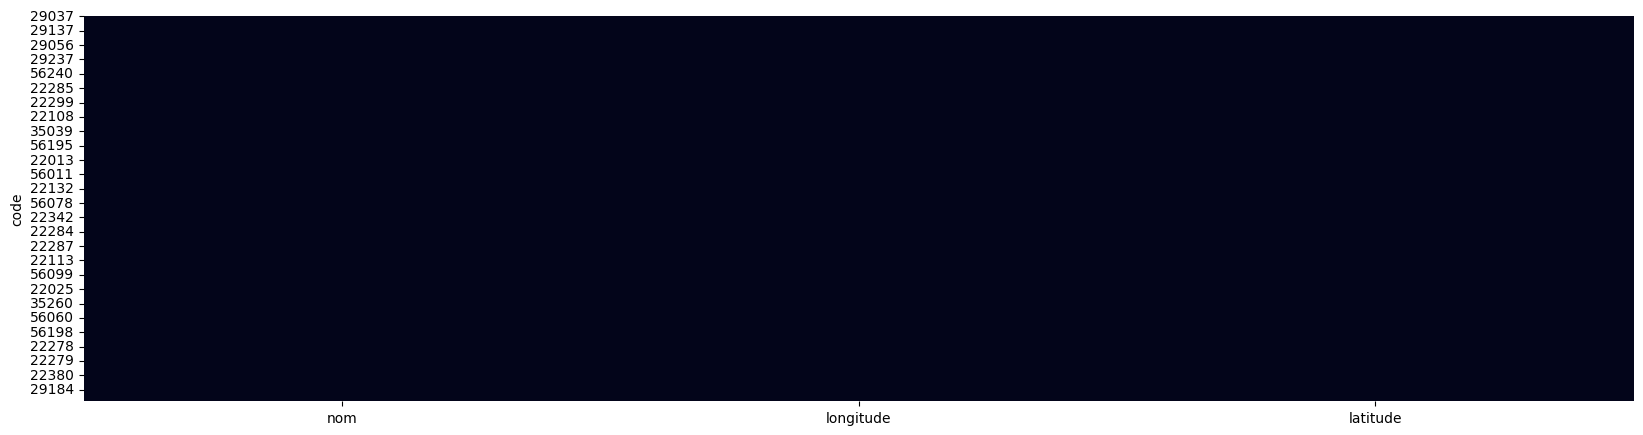

In [177]:
print(commune_df.shape)
plt.figure(figsize=(20,5))
sns.heatmap(commune_df.isna(), cbar=False)

In [270]:
long, lat = [], []
for i in commune_df.index:
    lo, la = commune_df.iloc[i,0].split(',')
    long.append(lo)
    lat.append(la)
    
commune_df['longitude'] = long
commune_df['latitude'] = lat
commune_df.drop(['Geo Point'], axis=1, inplace=True)

commune_df.columns = ['nom', 'code', 'longitude', 'latitude']
commune_df.set_index(['code'], inplace=True)
commune_df.head()

,nom,longitude,latitude
code,,,
29037,COMBRIT,47.8871419559671,-4.164161134106372
29061,GOUESNOU,48.446702017978325,-4.463235727523395
29097,LAMPAUL-GUIMILIAU,48.483723613082205,-4.040465447415241
29119,LANRIVOARÉ,48.4663585550616,-4.63454521582595
29134,LOCRONAN,48.098082470115166,-4.2131596293762605


# Traitement du fichier des niveaux d'interventions

In [583]:
niv_df = pd.read_csv('../data/sujet-1/niveau_interventions.csv', delimiter=';', encoding='latin-1')
niv_df.head()
print(niv_df.shape)

niv_df.columns = ['code', 'nivC', 'nivR']
niv_df.set_index(['code'], inplace=True)
niv_df.head()

(1208, 3)


,nivC,nivR
code,,
22001,Bas,Bas
22002,Bas,Haut
22003,Bas,Très Bas
22004,Très Haut,Très Haut
22005,Moyen,Haut


<AxesSubplot: >

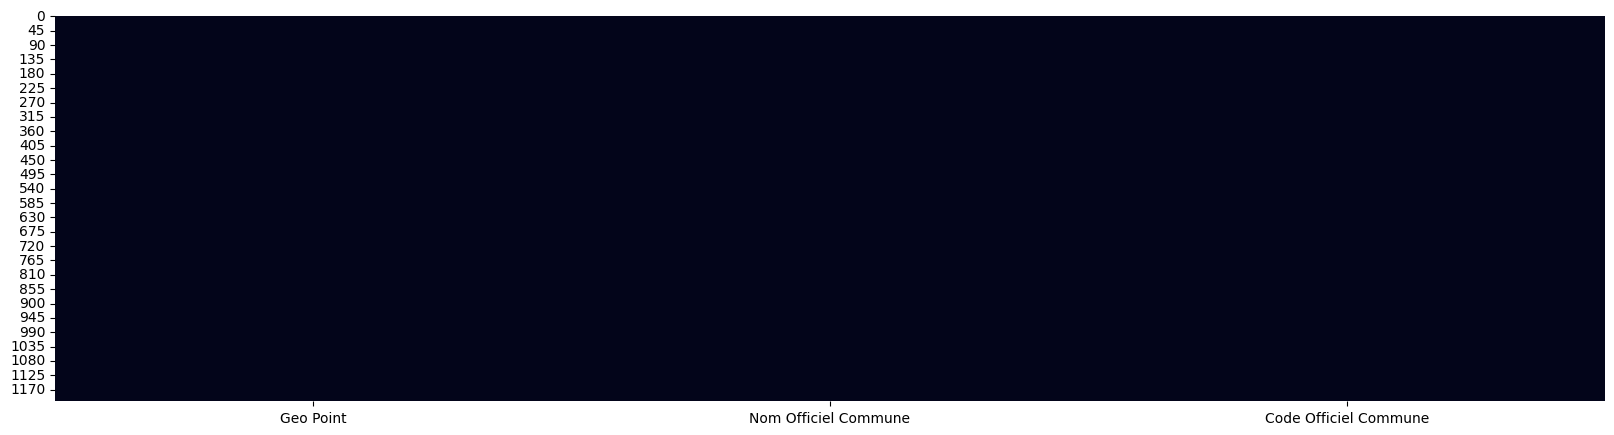

In [145]:
plt.figure(figsize=(20,5))
sns.heatmap(niv_df.isna(), cbar=False)

## Etude des niveaux d'intervention

In [109]:
for col in niv_df.columns[niv_df.dtypes == 'object']:
    print(f'{col :-<60} {niv_df[col].unique()}')

nivC-------------------------------------------------------- ['Bas' 'Très Haut' 'Moyen' 'Très Bas' 'Haut']
nivR-------------------------------------------------------- ['Bas' 'Haut' 'Très Bas' 'Très Haut' 'Moyen']


<AxesSubplot: >

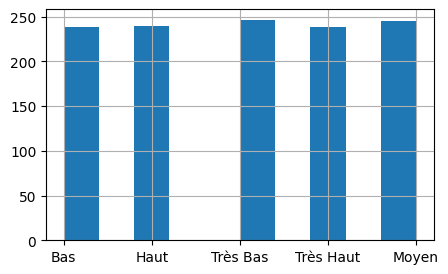

In [110]:
#niv_df['nivC'].apply(encoding_niv)
niv_df['nivR'].hist(figsize=(5,3))

<AxesSubplot: >

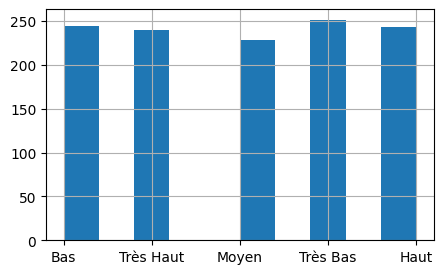

In [64]:
niv_df['nivC'].hist(figsize=(5,3))

In [584]:
def encoding_niv(x):
    return {'Très Bas': 1,
            'Bas': 2,
            'Moyen': 3,
            'Haut': 4,
            'Très Haut': 5}[x]


def couleur_niv(x):
    return {1: 'b',
            2: 'g',
            3: 'y',
            4: 'orange',
            5: 'r'}[x]

In [585]:
niv_df['nivC'] = niv_df['nivC'].apply(encoding_niv)
niv_df['nivR'] = niv_df['nivR'].apply(encoding_niv)
niv_df['nivIntervention'] = niv_df.sum(axis=1) / 2
niv_df['nivIntervention'] = niv_df['nivIntervention'].astype({'nivIntervention': int}) 

niv_df['color'] = niv_df['nivIntervention'].apply(couleur_niv)

niv_df.head()

,nivC,nivR,nivIntervention,color
code,,,,
22001,2,2,2,g
22002,2,4,3,y
22003,2,1,1,b
22004,5,5,5,r
22005,3,4,3,y


# Traitement du fichier des temps de trajet

In [355]:
trajet_df = pd.read_csv('../data/sujet-1/temps_trajet30.csv', delimiter=';', encoding='latin-1')

In [701]:
trajet_df = trajet_df[trajet_df['durée']<=1800]
trajet_df.reset_index(inplace=True, drop=True)
trajet_df = trajet_df[trajet_df.duplicated()==False]
print(trajet_df.shape)
trajet_df.head()

(51767, 3)


,depart,destination,durée
0,COMBRIT,COMBRIT,0.0
1,COMBRIT,ÎLE-TUDY,475.5
2,COMBRIT,TRÉMÉOC,561.8
3,COMBRIT,PONT-L'ABBÉ,558.4
4,COMBRIT,GOUESNACH,868.6


# Merge All

In [595]:
df = pd.merge(niv_df[['nivIntervention', 'color']], commune_df, left_index=True, right_index=True, how='inner')
df = df.astype({'longitude': float, 'latitude': float}) 

df.info()
print(df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 22001 to 56264
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nivIntervention  1206 non-null   int64  
 1   color            1206 non-null   object 
 2   nom              1206 non-null   object 
 3   longitude        1206 non-null   float64
 4   latitude         1206 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 56.5+ KB
(1206, 5)


,nivIntervention,color,nom,longitude,latitude
code,,,,,
22001,2,g,ALLINEUC,48.311574,-2.867065
22002,3,y,ANDEL,48.494105,-2.551043
22003,1,b,AUCALEUC,48.451792,-2.127619
22004,5,r,BÉGARD,48.634784,-3.291537
22005,3,y,BELLE-ISLE-EN-TERRE,48.531066,-3.381838


In [385]:
def nbVoisin(x):
    a= trajet_df['depart'] == x
    b= trajet_df['destination'] != x
    return sum(a*b)

In [951]:
dff = pd.merge(df, trajet_df, left_on='nom', right_on='depart', how='inner')
dff.drop(['nom'], axis=1, inplace=True)
print(dff.shape)

dff.columns = ['NivIntervention', 'Color', 'LongitudeDepart', 'LatitudeDepart', 'Depart', 'Destination', 'Duree']
dff.head()

(51706, 7)


,NivIntervention,Color,LongitudeDepart,LatitudeDepart,Depart,Destination,Duree
0,2,g,48.311574,-2.867065,ALLINEUC,ALLINEUC,0.0
1,2,g,48.311574,-2.867065,ALLINEUC,LE BODÉO,430.0
2,2,g,48.311574,-2.867065,ALLINEUC,UZEL,523.1
3,2,g,48.311574,-2.867065,ALLINEUC,MERLÉAC,629.0
4,2,g,48.311574,-2.867065,ALLINEUC,PLUC-L'HERMITAGE,649.9


# Visualisation

In [698]:
dfw_geo = geopandas.read_file('../data/sujet-1/geoFR.geojson')
dfw_geo.rename(columns = {'com_uu2020_code': 'code'}, inplace=True)
dfw_geo.set_index(['code'], inplace=True)

dfw_geo = dfw_geo[['geometry', 'com_name_upper']]

In [699]:
dfw_geo = dfw_geo.merge(df, left_on='com_name_upper', right_on='nom', how='inner')
dfw_geo.drop(['com_name_upper'], axis=1, inplace=True)

dfw_geo = dfw_geo[dfw_geo.isna()==False]
dfw_geo.dropna(axis=0)

,geometry,nivIntervention,color,nom,longitude,latitude
0,"POLYGON ((-4.20783 47.89344, -4.20724 47.89301...",5,r,COMBRIT,47.887142,-4.164161
1,"POLYGON ((-4.43090 48.45915, -4.43146 48.45949...",5,r,GOUESNOU,48.446702,-4.463236
2,"POLYGON ((-4.01651 48.50160, -4.01692 48.50198...",4,orange,LAMPAUL-GUIMILIAU,48.483724,-4.040465
3,"POLYGON ((-4.61267 48.48335, -4.61290 48.48358...",2,g,LANRIVOARÉ,48.466359,-4.634545
4,"POLYGON ((-4.20197 48.11180, -4.20242 48.11062...",2,g,LOCRONAN,48.098082,-4.213160
...,...,...,...,...,...,...
1213,"POLYGON ((-2.25824 48.55926, -2.25704 48.55927...",2,g,SAINT-LORMEL,48.551527,-2.235621
1214,"POLYGON ((-2.33813 48.52897, -2.33628 48.53008...",2,g,SAINT-PÔTAN,48.557422,-2.293197
1215,"POLYGON ((-3.14168 48.28305, -3.14427 48.28314...",1,b,SAINTE-TRÉPHINE,48.265764,-3.169668
1216,"POLYGON ((-3.14048 48.62686, -3.14022 48.62748...",1,b,SQUIFFIEC,48.637394,-3.166729


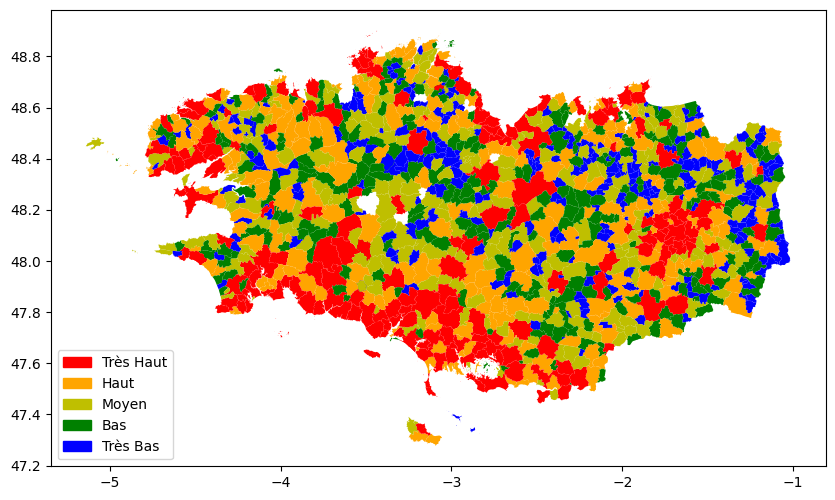

In [700]:
dfw_geo.loc[:1205,'geometry'].plot(figsize=(10,10), color=dfw_geo.color)

r_legend = mpatches.Patch(color='r', label='Très Haut')
orange_legend = mpatches.Patch(color='orange', label='Haut')
y_legend = mpatches.Patch(color='y', label='Moyen')
g_legend = mpatches.Patch(color='g', label='Bas')
b_legend = mpatches.Patch(color='b', label='Très Bas')

plt.legend(handles=[r_legend,orange_legend,y_legend,g_legend,b_legend], loc='lower left')

<AxesSubplot: >

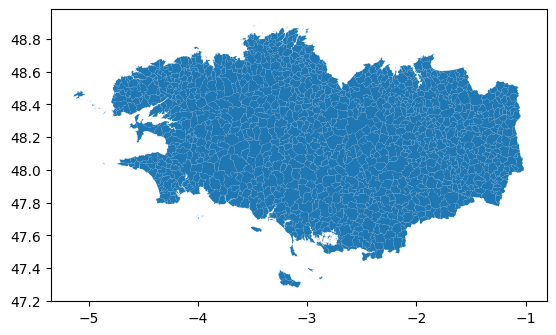

In [673]:
a = geopandas.read_file('../data/sujet-1/geoFR.geojson')
a.plot()

# Modeling

In [430]:
kmeans = KMeans(n_clusters=5, random_state=0, max_iter=1000, n_init='auto')
X = dff.drop(['Depart', 'Destination', 'NivIntervention'], axis=1)
Y = dff['NivIntervention']

In [703]:
wt_kmeansclus = kmeans.fit(X, sample_weight=Y)
predicted_kmeans = kmeans.predict(X, sample_weight=Y)

In [704]:
trajet_df.head()

,depart,destination,durée
0,COMBRIT,COMBRIT,0.0
1,COMBRIT,ÎLE-TUDY,475.5
2,COMBRIT,TRÉMÉOC,561.8
3,COMBRIT,PONT-L'ABBÉ,558.4
4,COMBRIT,GOUESNACH,868.6


In [710]:
X = trajet_df[['depart', 'destination', 'durée']]
X = trajet_df[['durée']]
from sklearn import preprocessing

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

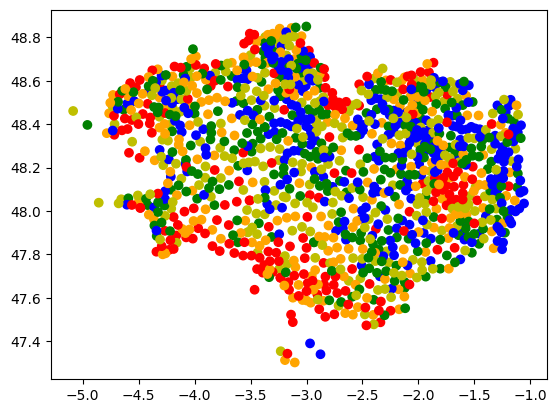

In [732]:
plt.scatter(dfw_geo.latitude, dfw_geo.longitude,color=dfw_geo.color)

In [938]:
dfw_geo.head()

,geometry,nivIntervention,color,nom,longitude,latitude,clust
0,"POLYGON ((-4.20783 47.89344, -4.20724 47.89301...",5,r,COMBRIT,47.887142,-4.164161,6
1,"POLYGON ((-4.43090 48.45915, -4.43146 48.45949...",5,r,GOUESNOU,48.446702,-4.463236,6
2,"POLYGON ((-4.01651 48.50160, -4.01692 48.50198...",4,orange,LAMPAUL-GUIMILIAU,48.483724,-4.040465,6
3,"POLYGON ((-4.61267 48.48335, -4.61290 48.48358...",2,g,LANRIVOARÉ,48.466359,-4.634545,7
4,"POLYGON ((-4.20197 48.11180, -4.20242 48.11062...",2,g,LOCRONAN,48.098082,-4.213160,7


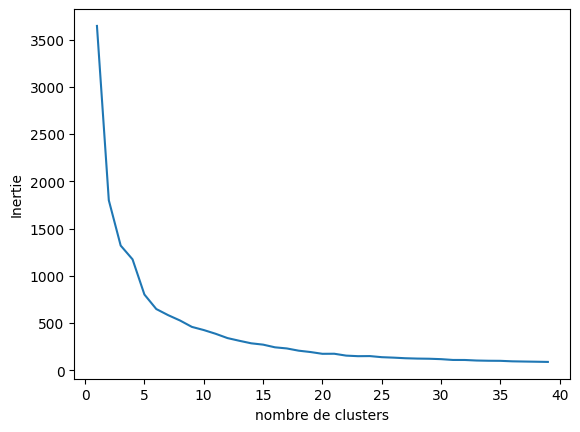

In [944]:
Xs = np.array(dfw_geo[['latitude', 'longitude', 'nivIntervention']])
X = np.array(dfw_geo[['latitude', 'longitude', 'nivIntervention']])

def elbow_method():
    inertia = []

    for k in range(1,40):
        km = KMeans(n_clusters=k, n_init='auto')
        km.fit(X)
        inertia.append(km.inertia_) 

    plt.plot(range(1,40), inertia)
    plt.xlabel('nombre de clusters')
    plt.ylabel('Inertie')

elbow_method()

In [947]:
kmeans = KMeans(n_clusters=14, n_init='auto')
kmeans.fit(X)
cluster_centers = kmeans.cluster_centers_

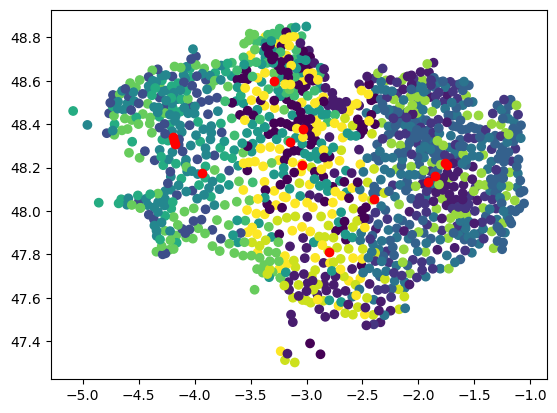

In [948]:
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='r')

In [861]:
dd = dfw_geo
#dfw_geo.loc[:1205,'geometry'].plot(figsize=(10,10), color=dfw_geo.color)

dd['clust'] = kmeans.labels_
dd['clust'] = dd['clust'].astype('int64')

In [924]:
def makeDelimits(model, df0):
    delimits = []    
    lp = []
    for i in range(kmeans.n_clusters):
        l = []
        for ind in df0.index:
            if df0.loc[ind, 'clust'] == i:
                coord = [df0.loc[ind,'latitude'], df0.loc[ind,'longitude'], df0.loc[ind,'geometry']]
                lp.append(df0.loc[ind,'geometry'])
                l.append(coord)
        delimits.append(l)
    return delimits, lp

In [936]:
delimits, lp = makeDelimits(kmeans, dd)
for i in range(len(lp)):
    lp[i]
#lp[3]
#pd.DataFrame(lp[3])
#np.array(delimits[0])#[:,].plot(figsize=(10,10))
#pd.DataFrame(np.array(delimits[0])[:,2]).plot(figsize=(10,10))
#np.array(delimits[0])[:,2]

bretagne = folium.Map(location=[48.202047, -2.932644], zoom_start=8, tiles='Stamen Toner')

#for zone_i in delimits:
zone = folium.Polygon(delimits[0], fill=True, color='red').add_to(bretagne)
    

bretagne

<AxesSubplot: >

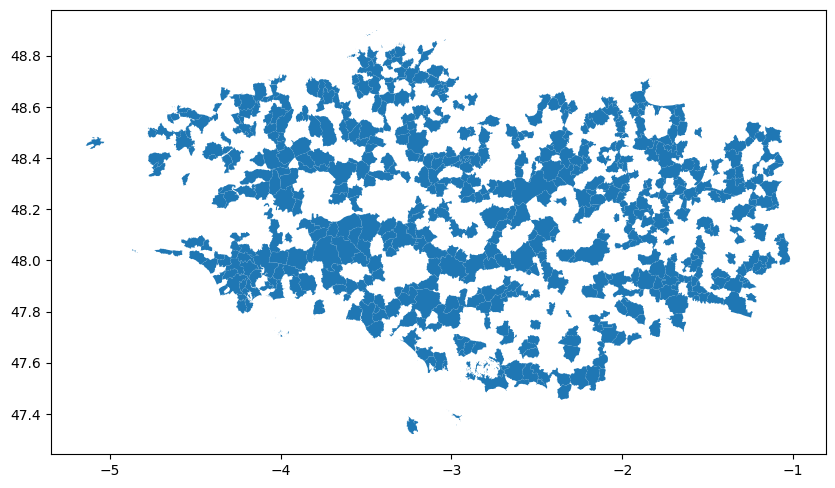

In [833]:
dfw_geo.loc[:1205:2,'geometry'].plot(figsize=(10,10))

In [840]:
kmeans.labels_

array([6, 6, 6, ..., 5, 5, 3], dtype=int32)

In [895]:
dfw_geo

,geometry,nivIntervention,color,nom,longitude,latitude,clust
0,"POLYGON ((-4.20783 47.89344, -4.20724 47.89301...",5,r,COMBRIT,47.887142,-4.164161,6
1,"POLYGON ((-4.43090 48.45915, -4.43146 48.45949...",5,r,GOUESNOU,48.446702,-4.463236,6
2,"POLYGON ((-4.01651 48.50160, -4.01692 48.50198...",4,orange,LAMPAUL-GUIMILIAU,48.483724,-4.040465,6
3,"POLYGON ((-4.61267 48.48335, -4.61290 48.48358...",2,g,LANRIVOARÉ,48.466359,-4.634545,7
4,"POLYGON ((-4.20197 48.11180, -4.20242 48.11062...",2,g,LOCRONAN,48.098082,-4.213160,7
...,...,...,...,...,...,...,...
1213,"POLYGON ((-2.25824 48.55926, -2.25704 48.55927...",2,g,SAINT-LORMEL,48.551527,-2.235621,1
1214,"POLYGON ((-2.33813 48.52897, -2.33628 48.53008...",2,g,SAINT-PÔTAN,48.557422,-2.293197,1
1215,"POLYGON ((-3.14168 48.28305, -3.14427 48.28314...",1,b,SAINTE-TRÉPHINE,48.265764,-3.169668,5
1216,"POLYGON ((-3.14048 48.62686, -3.14022 48.62748...",1,b,SQUIFFIEC,48.637394,-3.166729,5
